In [1]:
%config Completer.use_jedi = False

<font size="5">
    <b>"Warten oder Kaufen", Gruppe A mit logistischer Regression</b>
</font>

## Import von  Modulen


In [2]:
# Importiere Module und Methoden
#%matplotlib ipympl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

## Import der Daten

Die Daten und Merkmale wurden im ersten Teil des Projektes bearbeitet. Hier werden diese Daten aus lokal gespeicherten CSV-Dateien geladen:

In [3]:
#Read OHE Data shortcut
train_set_orig = pd.read_csv("./train_set.csv")
train_set = pd.read_csv("./train_set_ohe.csv")
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83624 entries, 0 to 83623
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Departure_FRA                        83624 non-null  float64
 1   Departure_STN                        83624 non-null  float64
 2   Departure_SXF                        83624 non-null  float64
 3   Destination_FRA                      83624 non-null  float64
 4   Destination_STN                      83624 non-null  float64
 5   Destination_SXF                      83624 non-null  float64
 6   Price_Dev_Cat_Falling                83624 non-null  float64
 7   Price_Dev_Cat_Rising                 83624 non-null  float64
 8   Price_Dev_Cat_Steady                 83624 non-null  float64
 9   Request_Day                          83624 non-null  float64
 10  Flight_Day                           83624 non-null  float64
 11  buy                         

### Speichern der Merkmale im Dataframe - Erzeuge Trainings- und Testdatensatz mit train_test_split()

In [4]:
customFeaturesDf = train_set[["Departure_FRA", "Departure_STN", "Departure_SXF", "Destination_FRA",
                              "Destination_STN", "Destination_SXF", "Price_Dev_Cat_Falling", 
                              "Price_Dev_Cat_Rising", "Price_Dev_Cat_Steady", "Price_In_Eur",
                              "Price_Dev", "Price_Dev_Three_Days", "Same_Day_Request_route_Flight_price",
                              "Request_Month", "Request_Time", "Request_Day", "Flight_Day", "Departure_hour",
                              "Hours_to_Flight", "Request_Count", "Request_Count_Sum", "Last_Request_Bool",
                              "Is_Holiday_UK", "Is_Holiday_GER",
                              "Is_School_Holiday_BER", "Is_School_Holiday_FRA", "Is_School_Holiday_UK", "buy"]]

In [5]:
X = customFeaturesDf.iloc[:,0:-1]
y = customFeaturesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y, shuffle=True)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape, "\n")

Shape of X_train: (66899, 27)
Shape of X_test: (16725, 27)
Shape of y_train: (66899,)
Shape of y_test: (16725,) 



### Standardisierung der Variance auf 1 um Rauschen in den Datensatz zu veringern und die Skalierung der Dimensionen zu vereinheitlichen.

X_scale: Alle 21 Features

In [6]:
scaler = StandardScaler(with_mean=False)

# scale variance to 1
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
X_train_scaled.shape

(66899, 27)

## Hauptkomponentenanalyse (PCA): Reduzierung der Menge der Merkmale

Aufgrund der Erkenntnisse, die aus der PCA gewonnen wurden (siehe oben bei SVM), werden hier zunächst die merkmalsreduzierten Trainingsdaten mit 18 von insgesamt 32 Merkmalen genutzt.

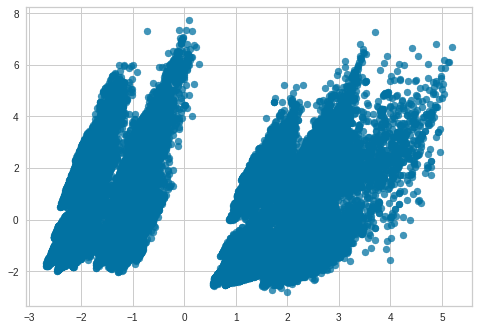

In [8]:
# reduced featured space to 18 with PCA
from yellowbrick.features import PCA

pca = PCA(n_components=0.95)
pca.fit(X_train_scaled) 
X_train_reduced = pca.transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)
#X_train_reduced.shape

## Training des Classifiers

### Training mit PCA-reduziertem Merkmalssatz

In [9]:
# possible solvers are: 'liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'
logReg_clf = LogisticRegression(random_state=42, solver="lbfgs", max_iter=3000,penalty='l2').fit(X_train_reduced, y_train)

X_train_reduced_scores = logReg_clf.predict(X_train_reduced)

#Cobfusion Matrix
from sklearn.metrics import confusion_matrix

print("Confusion Matrix, TrainSet:\n",confusion_matrix(y_train, X_train_reduced_scores))

#scores = cross_val_score(logReg_clf, X_train_reduced, y_train, cv=10, n_jobs=-1)

#Classification report, recall_score, precision_score
from sklearn.metrics import classification_report, recall_score, precision_score

print("\nClassification Report:\n",classification_report(y_train, X_train_reduced_scores,  digits=3))

Confusion Matrix, TrainSet:
 [[51924     1]
 [14972     2]]

Classification Report:
               precision    recall  f1-score   support

           0      0.776     1.000     0.874     51925
           1      0.667     0.000     0.000     14974

    accuracy                          0.776     66899
   macro avg      0.721     0.500     0.437     66899
weighted avg      0.752     0.776     0.678     66899



### Testen PCA-reduzierter Merkmalssatz mit eigenen Testdaten

In [10]:
X_test_reduced_scores = logReg_clf.predict(X_test_reduced)

print("Confusion Matrix, TestSet:\n", confusion_matrix(y_test, X_test_reduced_scores))

print("\nClassification Report:\n",classification_report(y_test, X_test_reduced_scores, digits=3))

Confusion Matrix, TestSet:
 [[12980     1]
 [ 3744     0]]

Classification Report:
               precision    recall  f1-score   support

           0      0.776     1.000     0.874     12981
           1      0.000     0.000     0.000      3744

    accuracy                          0.776     16725
   macro avg      0.388     0.500     0.437     16725
weighted avg      0.602     0.776     0.678     16725



### Training mit normalen Merkmalssatz, weil der PCA-reduzierte zu schlechte Ergebnisse abliefert

In [11]:
# possible solvers are: 'liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'
logReg_clf = LogisticRegression(random_state=42, solver="lbfgs", max_iter=3000,penalty='l2').fit(X_train_scaled, y_train)

X_train_scaled_scores = logReg_clf.predict(X_train_scaled)

#Confusion Matrix
print("Confusion Matrix, TrainSet:\n",confusion_matrix(y_train, X_train_scaled_scores))

#classification report
print("\nClassification Report:\n",classification_report(y_train, X_train_scaled_scores, digits=3))

Confusion Matrix, TrainSet:
 [[50272  1653]
 [11190  3784]]

Classification Report:
               precision    recall  f1-score   support

           0      0.818     0.968     0.887     51925
           1      0.696     0.253     0.371     14974

    accuracy                          0.808     66899
   macro avg      0.757     0.610     0.629     66899
weighted avg      0.791     0.808     0.771     66899



In [12]:
#Testdaten
X_test_scaled_scores = logReg_clf.predict(X_test_scaled)

print("Confusion Matrix, TestSet:\n", confusion_matrix(y_test, X_test_scaled_scores))


#classification report
print("\nClassification Report:\n",classification_report(y_test,X_test_scaled_scores,  digits=3))

Confusion Matrix, TestSet:
 [[12580   401]
 [ 2849   895]]

Classification Report:
               precision    recall  f1-score   support

           0      0.815     0.969     0.886     12981
           1      0.691     0.239     0.355      3744

    accuracy                          0.806     16725
   macro avg      0.753     0.604     0.620     16725
weighted avg      0.787     0.806     0.767     16725



## Optimierung der Hyperparameter

In [13]:
#LogREgression Optimierung des Hyperparameter
# Grid search cross validation

#Source: https://towardsdatascience.com/implement-logistic-regression-with-l2-regularization-from-scratch-
#                in-python-20bd4ee88a59#4077
#penalty : None or 'l2', default='l2'.
#          Option to perform L2 regularization.
#          C : float, default=0.1
#          Inverse of regularization strength; must be a positive float. 
#          Smaller values specify stronger regularization.
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = {'C': [0.00001, 0.0001, 0.001, 0.01,0.1, 1, 100, 10000, 100000, 1000000, 10000000, 100000000], "penalty":["l2"] }

logReg_cv=GridSearchCV(logReg_clf,grid,cv=10)
logReg_cv.fit(X_train_scaled,y_train)

print("tuned hpyerparameters :(best parameters) ",logReg_cv.best_params_)
print("accuracy :",logReg_cv.best_score_)

print("Best parameters set found on X_train:")
print()
print(logReg_cv.best_params_)
print()
print("Grid scores on train_set:")
print()
means = logReg_cv.cv_results_['mean_test_score']
stds = logReg_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, logReg_cv.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

tuned hpyerparameters :(best parameters)  {'C': 100000, 'penalty': 'l2'}
accuracy : 0.8080091134162439
Best parameters set found on X_train:

{'C': 100000, 'penalty': 'l2'}

Grid scores on train_set:

0.776 (+/-0.000) for {'C': 1e-05, 'penalty': 'l2'}
0.789 (+/-0.003) for {'C': 0.0001, 'penalty': 'l2'}
0.806 (+/-0.007) for {'C': 0.001, 'penalty': 'l2'}
0.808 (+/-0.007) for {'C': 0.01, 'penalty': 'l2'}
0.808 (+/-0.007) for {'C': 0.1, 'penalty': 'l2'}
0.808 (+/-0.007) for {'C': 1, 'penalty': 'l2'}
0.808 (+/-0.007) for {'C': 100, 'penalty': 'l2'}
0.808 (+/-0.007) for {'C': 10000, 'penalty': 'l2'}
0.808 (+/-0.007) for {'C': 100000, 'penalty': 'l2'}
0.808 (+/-0.007) for {'C': 1000000, 'penalty': 'l2'}
0.808 (+/-0.007) for {'C': 10000000, 'penalty': 'l2'}
0.808 (+/-0.007) for {'C': 100000000, 'penalty': 'l2'}


In [14]:
# ohne l2-Penalty
grid = {'C': [0.00001, 0.0001, 0.001, 0.01,0.1, 1, 10, 10000, 100000, 1000000]}

logReg_cv=GridSearchCV(logReg_clf,grid,cv=10)
logReg_cv.fit(X_train_scaled,y_train)

print("tuned hpyerparameters :(best parameters) ",logReg_cv.best_params_)
print("accuracy :",logReg_cv.best_score_)

print("Best parameters set found on X_train:")
print()
print(logReg_cv.best_params_)
print()
print("Grid scores on train_set:")
print()
means = logReg_cv.cv_results_['mean_test_score']
stds = logReg_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, logReg_cv.cv_results_['params']):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

tuned hpyerparameters :(best parameters)  {'C': 100000}
accuracy : 0.8080091134162439
Best parameters set found on X_train:

{'C': 100000}

Grid scores on train_set:

0.776 (+/-0.000) for {'C': 1e-05}
0.789 (+/-0.003) for {'C': 0.0001}
0.806 (+/-0.007) for {'C': 0.001}
0.808 (+/-0.007) for {'C': 0.01}
0.808 (+/-0.007) for {'C': 0.1}
0.808 (+/-0.007) for {'C': 1}
0.808 (+/-0.007) for {'C': 10}
0.808 (+/-0.007) for {'C': 10000}
0.808 (+/-0.007) for {'C': 100000}
0.808 (+/-0.007) for {'C': 1000000}


Es macht offensichtlich keinen Unterschied, ob für den Paramter 'C' ein Wert von 100.000, oder ob der 'default'-Wert 'C=1' gewählt wird. An dem Ergebnis ändert dies nichts. Im weiteren wird als der Parameter 'C=1' gewählt.

## Bewertung mit monetärem Maß

### Import der Methode und Skalieren der Daten

In [15]:
# The model quality evaluation function expects a Pandas dataframe with at least the following columns:
# Request_Date          int64
# flight_unique_id     object
# Price               float64
# buy                    bool

def model_quality_evaluation(df):
    # Make a copy of the provided dataframe as to not modify the original.
    df = df.copy()

    # Convert 'Price' to whole cents and store as integers to avoid floating point errors.
    df['Price'] = df['Price'] * 100
    df['Price'] = df['Price'].astype(int)

    # Initialize a variable that stores the sum of all our balances.
    sum_balances = 0

    # Get a list of all 'flight_unique_id'.
    flight_unique_ids = df['flight_unique_id'].unique()

    # Iterate over all 'flight_unique_id'.
    for flight_unique_id in flight_unique_ids:
        # Get a subset of the data for the specified 'flight_unique_id'.
        df_subset = df[df['flight_unique_id'] == flight_unique_id]

        # Get all request dates except for the latest request date before departure.
        # At the latest request date before departure we need to buy a ticket anyway,
        # so we don't care about this specific request date.
        request_dates = df_subset[df_subset['Request_Date'] != df_subset['Request_Date'].max()]

        # Make sure request dates are sorted in descending order.
        request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)

        # Get the ticket price from the latest request date before departure,
        # because we certainly have to buy a ticket at this date.
        last_buying_price = df_subset[df_subset['Request_Date'] == df_subset['Request_Date'].max()]['Price'].values[0]

        # Iterate over the remaining request dates
        for _, row in request_dates.iterrows():
            # and check wether the model wants to buy a ticket at the specific request date.
            if(row['buy'] == 1):
                # If the model decides to buy a ticket the last buying price is set to the
                # price point of this request date and the balance doesn't change.
                last_buying_price = row['Price']
            else:
                # If the models decides to not buy a ticket the balance equals the
                # the current ticket price minus the last buying price.
                current_price = row['Price']
                balance = current_price - last_buying_price

                # The balance is added to the sum of all balances.
                sum_balances = sum_balances + balance

    # Return the sum of all our previously calculated balances.
    return sum_balances / 100

In [16]:
X = customFeaturesDf.iloc[:,0:-1]
y = customFeaturesDf.iloc[:,-1]
scaler = StandardScaler(with_mean=False)

# scale variance to 1
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Eigentliche monetäre Bewertung

In [17]:
logReg_clf02 = LogisticRegression(C=1, random_state=42, solver="lbfgs", max_iter=3000)

# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
money_scores = []

# for each fold create a dataframe
for train_index, test_index in skf.split(X_scaled, y): # split() return index of each fold
	# get each fold train, test fold with index index 
	x_train_fold, x_test_fold = X_scaled[train_index], X_scaled[test_index]
	y_train_fold, y_test_fold = y[train_index], y[test_index]
	logReg_clf02.fit(x_train_fold, y_train_fold)
	y_pred = logReg_clf02.predict(x_test_fold)
	
	# make test df to evaluate
	X_train_1 = train_set_orig.loc[test_index]
	df = pd.DataFrame(x_test_fold, index=test_index)
	df["buy"] = y_pred
	df["flight_unique_id"] = X_train_1["flight_unique_id"]
	df["Request_Date"] = X_train_1["Request_Date"]
	df["Price"] = X_train_1["Price_In_Eur"]
 
	# eval with custom func and append
	score = model_quality_evaluation(df)
	money_scores.append(score)


# Print the output.
print('List of possible money scores:', money_scores)
print('\nMean Money:',
	np.mean(money_scores))
print('\nStandard Deviation is:', np.std(money_scores))

/tmp/ipykernel_10069/4028796872.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)
/tmp/ipykernel_10069/4028796872.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)
/tmp/ipykernel_10069/4028796872.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  request_dates.sort_values(by='Re

List of possible money scores: [-467308.16, -481619.0, -494242.81, -498824.5, -503630.01]

Mean Money: -489124.896

Standard Deviation is: 13137.595960279197


## Verbesserung des Ergebnisses des monetären Maßes 
### Verschiebung des Threshold (Grenzwert der Entscheidungsfunktion)
True Positive (TP-Werte) sind die korrekten 'bait'-Modellentscheidungen. Demnach ergeben sich:
- TP ... korrekte 'bait'-Entscheidungen,
- TN ... korrekte 'wait'-Entscheidungen,
- FP ... falsche 'bait'-Entscheidungen, d.h. man hätte warten sollen,
- FN ... falsche 'Wait'-Entscheidungen, d.h. man hätte kaufen sollen.
    
Das monetäre Gütemaß begünstigt falsche 'Bait' - Entscheidungen (FP), weil hierbei keine negativen Kostenwerte entstehen. Durch -im Zweifel- falsche Kaufempfehlungen lassen sich also Verluste vermeiden.

Hingegen führen falsche 'Wait'-Entscheidungen immer zu Verlusten. Ziel muss es also sein, möglichst keine falschen 'Wait'-Entscheidungen zu erhalten. Falsche 'Wait'-Entscheidungen (FN) müssen also minimiert werden. Wir versuchen daher im Folgenden, einen möglichst hohen Recall (TP/(TP+FN))zu erzielen. Dies kann durch ein Verschieben des Threshold-Wertes erreicht werden. 

Doch zunächst werden die Precision- und Recall-Kurve gemeinsam dargestellt:

### Precission-Recall-Kurve

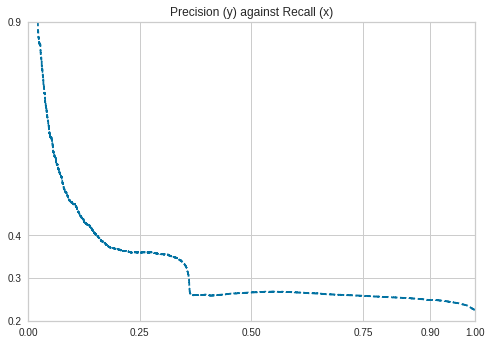

In [18]:
#CM-Vorbereitung: Vorhersage der Ergebnisse
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

y_train_pred_PR_Curve = cross_val_predict(logReg_clf02, X_scaled, y, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y, y_train_pred_PR_Curve)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


ax.set(xlim=(0, 1), xticks=(0, 0.25,0.5, 0.75,0.9,1),
       ylim=(0.2, 0.9), yticks=(0.2, 0.3, 0.4, 0.9))

ax.plot(recalls[:-1], precisions[:-1], "b--", label="y-Precisions")
ax.set_title('Precision (y) against Recall (x)')
plt.show()



Man kann in der Grafik oben erkennen, dass ein hoher Recall von über 90% einen Precision-Wert von ca. 25% ergeben dürfte. Die folgende Grafik, die 'Threshold-Recall-Precision'-Kurve bestätigt diese Annahme:

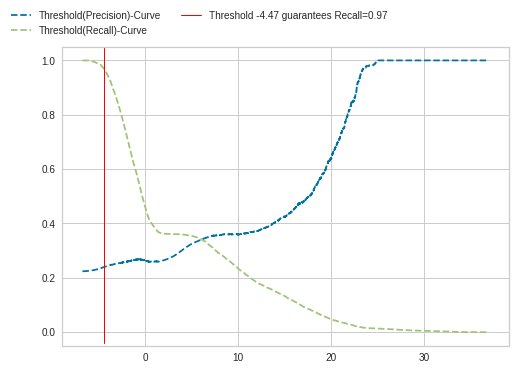

In [19]:
#Quelle: A.Geron 'Hands on Machine Learning...', O'Reilly, 2nd Edition, p.95
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recalls")
    plt.axvline(x=-4.465, ymin=0.01, color='red', linewidth=1)
    plt.legend(['Threshold(Precision)-Curve', 'Threshold(Recall)-Curve',
                'Threshold -4.47 guarantees Recall=0.97'], bbox_to_anchor=(0.75, 1.15), ncol=2)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Einen konkreten Grenzwert erreichen (Quelle: A.Geron)

Um z.B. einen 97%-igen Recall zu erreichen,

    Ziel: R=>97

muss ein passender Grenzwert der Entscheidungsfunktion gewählt werden. Konkret wird nach dem niedrigsten Grenzwert ('threshold', mit der Methode np.argmin()) gesucht, der einen  97%-igen Recall-Wert garantiert:


In [20]:
# argmin() ... returns the indices of the minimum value along an axis.

threshold_97_recall = thresholds[np.argmin(recalls >= 0.97)] 

print("\nGrenzwert, ab dem in 'wait' klassifiziert wird....\n",threshold_97_recall)


Grenzwert, ab dem in 'wait' klassifiziert wird....
 -4.465550679502887


Um mit diesem Grenzwert Vorhersagen zu treffen, kann auch -anstelle des Classifiers- die *predict()*-Methode gewählt werden. Im Folgenden sind die *'y-scores'* all diejenigen Ergebniswerte der Entscheidungsfunktion für jeden DS, die über dem gewünschten Grenzwert liegen. Es handelt sich also um genau die Labelwerte, mit denen eine bestimmter 'Recall'-Werte, z.B. mind 97%, erreicht wird.

In [21]:
y_train_pred_97 = (y_train_pred_PR_Curve >= threshold_97_recall)

#confusion matrix bei verändertem Grenzwert
print("Confusion matrix:\n", confusion_matrix(y, y_train_pred_97))

#classification report
print("\nClassification Report:\n",classification_report(y, y_train_pred_97,  digits=3))

Confusion matrix:
 [[ 7216 57690]
 [  562 18156]]

Classification Report:
               precision    recall  f1-score   support

           0      0.928     0.111     0.199     64906
           1      0.239     0.970     0.384     18718

    accuracy                          0.303     83624
   macro avg      0.584     0.541     0.291     83624
weighted avg      0.774     0.303     0.240     83624



## Erneute Bewertung: Monetäres Maß mit neuem Threshold

In [22]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
money_scores = []

# for each fold create a dataframe
for train_index, test_index in skf.split(X_scaled, y_train_pred_97): 
	# get each fold train, test fold with index index 
	x_train_fold, x_test_fold = X_scaled[train_index], X_scaled[test_index]
	y_train_fold, y_test_fold = y_train_pred_97[train_index], y_train_pred_97[test_index]
	logReg_clf02.fit(x_train_fold, y_train_fold)
	y_pred = logReg_clf02.predict(x_test_fold)
	
	# make test df to evaluate
	X_train_1 = train_set_orig.loc[test_index]
	df = pd.DataFrame(x_test_fold, index=test_index)
	df["buy"] = y_pred
	df["flight_unique_id"] = X_train_1["flight_unique_id"]
	df["Request_Date"] = X_train_1["Request_Date"]
	df["Price"] = X_train_1["Price_In_Eur"]
 
	# eval with custom func and append
	score = model_quality_evaluation(df)
	money_scores.append(score)


# Print the output.
print('List of possible money scores:', money_scores)
print('\nMean Money:',
	np.mean(money_scores))
print('\nStandard Deviation is:', np.std(money_scores))

/tmp/ipykernel_10069/4028796872.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)
/tmp/ipykernel_10069/4028796872.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  request_dates.sort_values(by='Request_Date', ascending=False, inplace=True)
/tmp/ipykernel_10069/4028796872.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  request_dates.sort_values(by='Re

List of possible money scores: [3089.22, 2382.04, 2168.78, 4279.42, 1806.55]

Mean Money: 2745.202

Standard Deviation is: 873.7722578887475


## Vorhersage mit Test-Datensatz für monetären Vergleich mit anderen Projektgruppen
### Testdatensatz laden und skalieren

In [23]:
X_test_set_ohe = pd.read_csv("./test_set_ohe.csv")

#Export vorbereiten
X_test_set = pd.read_csv("./test_set.csv")

#Sortieren der Testdaten, genau wie die OHE-Daten, um Zuordnung der Vorhersagen zu erhalten
X_test_set.sort_values(["flight_unique_id", "Request_Date"])

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur
0,1,2019-06-03T11:00:00Z,2019-07-02,7,2019-07-02 FR 145,STN-SXF,30.32
1,2,2019-06-03T23:00:00Z,2019-07-02,7,2019-07-02 FR 145,STN-SXF,44.53
2,3,2019-06-04T11:00:00Z,2019-07-02,7,2019-07-02 FR 145,STN-SXF,44.47
3,4,2019-06-04T23:00:00Z,2019-07-02,7,2019-07-02 FR 145,STN-SXF,44.47
4,5,2019-06-05T11:00:00Z,2019-07-02,7,2019-07-02 FR 145,STN-SXF,44.52
...,...,...,...,...,...,...,...
5578,5579,2019-07-30T23:00:00Z,2019-08-02,22,2019-08-02 FR 8545,SXF-STN,42.83
5579,5580,2019-07-31T11:00:00Z,2019-08-02,22,2019-08-02 FR 8545,SXF-STN,50.99
5580,5581,2019-07-31T23:00:00Z,2019-08-02,22,2019-08-02 FR 8545,SXF-STN,50.99
5581,5582,2019-08-01T11:00:00Z,2019-08-02,22,2019-08-02 FR 8545,SXF-STN,50.99


In [24]:
#test_set_ohe skalieren
scaler.fit(X_test_set_ohe)
X_test_scaled = scaler.transform(X_test_set_ohe)

### Vorhersage und Export der Testdaten

In [25]:
#Vorhersage mit skalierten ohe_Daten
X_testSet_scores = logReg_clf02.predict(X_test_scaled)


In [26]:
#Vorhersagen zu den originalen Testdaten als Spalte 'buy' hinzufuegen
X_test_set['buy']=X_testSet_scores

In [27]:
#Vorhergesagte Testdaten
X_test_set.to_csv("./test_set_predicted.csv", index=False)